Before running the next cell please add a shortcut to the shared folder at the root of your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Learning_with_Density_Matrices_and_Random_Features-Supplementary_Material/qmc/tf')
import layers as layers
import models as models

/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking layers.CrossProduct.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking layers.DensityMatrix2Dist.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking layers.DensityMatrixRegression.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))


In [ ]:
import warnings
import numpy as np
from sklearn.kernel_approximation import RBFSampler

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import numpy as np
import pylab as pl
import pandas as pd
import gzip

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle

In [ ]:
import sklearn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer

In [ ]:
from functions.keras_wrapper_qmc import KerasClassifier

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer

### example

In [ ]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape((60000,784))
X_test = X_test.reshape((10000,784))
#%%
np.random.RandomState(0)
#random_train = np.random.choice(range(X_train.shape[0]), 60000, replace=False)
#random_test = np.random.choice(range(X_test.shape[0]), 10000, replace=False)

#%%

# X_train = X_train[random_train,:]
# y_train = y_train[random_train]
# X_test = X_test[random_test,:]
# y_test = y_test[random_test]



X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("shape X_train : ", X_train.shape)
print("shape y_train : ", y_train.shape)
print("shape X_test : ", X_test.shape)
print("shape y_test : ", y_test.shape)

shape X_train :  (60000, 784)
shape y_train :  (60000,)
shape X_test :  (10000, 784)
shape y_test :  (10000,)


In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
gammas = [2**i for i in range(-10,10)]

In [ ]:
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [ ]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=196)
#pca.fit(X_train)
#X_train = pca.transform(X_train)
#X_test = pca.transform(X_test)

In [ ]:
#from sklearn.ensemble import RandomForestClassifier

#clf = RandomForestClassifier()
#clf.fit(X_train, y_train)
#print(clf.score(X_test, y_test))

In [ ]:
#from sklearn.ensemble import GradientBoostingClassifier

#clf = GradientBoostingClassifier()
#clf.fit(X_train, y_train)
#print(clf.score(X_test, y_test))

In [ ]:
input_dim = 784
component_dim = 784
num_classes = 10
gamma = 2**-5
random_state=0
num_eig=0
batch_size=32
epochs = 10

In [ ]:
gammas = [2**i for i in range(-15,5)]
componets_dim = [int(input_dim*1/5),int(input_dim*1/3),int(input_dim*1/2), input_dim*1,input_dim*2,input_dim*4,input_dim*8,input_dim*16,input_dim*32, input_dim*64, 1000]

num_eigs = [0] + [2**i for i in range(int(np.log2(component_dim)))]
scores = {}

In [ ]:
num_eigs

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256]

In [ ]:
name_file = '20201006_mnist_qmc_rff_vs_orf_scores.pkl'

In [ ]:
#with open(name_file, 'rb') as f:
#    scores = pickle.load(f)

In [ ]:
def create_model(input_dim, num_classes, component_dim=100, gamma=1, lr=0.01, decay=0.,
                  random_state=None, eig_percentage=0, initialize_with_rff=False,
                  type_of_rff="rff", fix_rff=False):
    '''This is a model generating function so that we can search over neural net
    parameters and architecture'''

    num_eig = round(eig_percentage * component_dim)

    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, decay=decay)

    if type_of_rff == 'rff':
        fm_x = layers.QFeatureMapRFF(input_dim, dim=component_dim, gamma=gamma, random_state=random_state)
    #else:
    #    fm_x = layers.QFeatureMapORF(input_dim, dim=component_dim, gamma=gamma, random_state=random_state)

    if initialize_with_rff:
        qmkdc = models.QMKDClassifier(fm_x=fm_x, dim_x=component_dim, num_classes=num_classes)
        qmkdc.compile()
        qmkdc.fit(X_train, y_train, epochs=1, batch_size=batch_size)

    qmkdc1 = models.QMKDClassifierSGD(input_dim=input_dim, dim_x=component_dim, num_eig=num_eig,
                                      num_classes=num_classes, gamma=gamma, random_state=random_state, fm_x=fm_x)

    if fix_rff:
        qmkdc1.layers[0].trainable = False

    qmkdc1.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

    if initialize_with_rff:
        qmkdc1.set_rhos(qmkdc.get_rhos())

    # qmkdc1.fit(X_train, y_train_bin, epochs=epochs, batch_size=batch_size)

    return qmkdc1

In [ ]:
model_mnist = create_model(input_dim, num_classes, component_dim=round(input_dim/2), gamma=2**-9, lr=0.00001, decay=1.000000e-06,
                  random_state=None, eig_percentage=0.1, initialize_with_rff=True,
                  type_of_rff="rff", fix_rff=False)

In [ ]:
#model_mnist.load_weights("/gdrive/My Drive/weights_mnits_model.h5")

In [ ]:
opt = keras.optimizers.RMSprop(lr=0.00000001,  decay=1.000000e-06)
model_mnist.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

transformer = OneHotEncoder(sparse=False)
y_train_bin = transformer.fit_transform(y_train[:, np.newaxis])

history = model_mnist.fit(X_train, y_train_bin, epochs=100, batch_size=8)

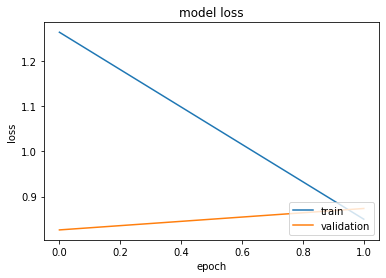

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [ ]:
out = model_mnist.predict(X_test, batch_size=batch_size)
print(accuracy_score(y_test, out.argmax(axis=1)))

0.9631


In [ ]:
model_mnist.save_weights("/gdrive/My Drive/weights_mnits_model gamma 000977 eig01 orf lr-5 compoover2.h5")

In [ ]:
import pandas as pd
pd.DataFrame([

dict(component_dim=round(input_dim/2), gamma=2**-9, lr=0.00001, decay=1.000000e-06,
                  random_state=None, eig_percentage=0.1, initialize_with_rff=True,
                  type_of_rff="orf", fix_rff=False, value = 0.9631),
dict(component_dim=input_dim*2, gamma=2**-6, lr=0.00001, decay=1.000000e-06,
                  random_state=None, eig_percentage=0.25, initialize_with_rff=True,
                  type_of_rff="orf", fix_rff=False, value = 0.9649),
 
dict(component_dim=input_dim*2, gamma=2**-5, lr=0.00001, decay=1.000000e-06,
                  random_state=None, eig_percentage=0.1, initialize_with_rff=True,
                  type_of_rff="rff", fix_rff=False, value = 0.9673),
              
dict(component_dim=input_dim*2, gamma=2**-10, lr=0.00001, decay=1.000000e-06,
                  random_state=None, eig_percentage=0.50, initialize_with_rff=False,
                  type_of_rff="rff", fix_rff=False, value = 0.12)
])

,component_dim,gamma,lr,decay,random_state,eig_percentage,initialize_with_rff,type_of_rff,fix_rff,value
0,392,0.001953,0.00001,0.000001,None,0.10,True,orf,False,0.9631
1,1568,0.015625,0.00001,0.000001,None,0.25,True,orf,False,0.9649
2,1568,0.031250,0.00001,0.000001,None,0.10,True,rff,False,0.9673
3,1568,0.000977,0.00001,0.000001,None,0.50,False,rff,False,0.1200
